<a href="https://colab.research.google.com/github/reyerick88-ai/FInanzas-InstitutoNeuro/blob/master/notebooks/train-yolov8-keypoint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train a YOLOv8 Keypoint Detection Model

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/yolov8-keypoint-detection-custom-train)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics.

In this guide, we will walk through how to train a YOLOv8 keypoint detection model.

If you notice that our notebook behaves incorrectly, let us know by [opening an issue on the Roboflow Notebooks repository](https://github.com/roboflow/notebooks/issues).

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading our [YOLOv8 keypoint detection training blog post](https://blog.roboflow.com/train-a-custom-yolov8-pose-estimation-model/).

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Checking that our Colab environment has a GPU
- Installing YOLOv8
- Preparing a dataset
- Training a model
- Running inference on our model
- Calculating the angle of two keypoints

Without further ado, let's get started!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Dec 10 05:37:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

To install YOL0v8, run the following command:

In [1]:
!pip install ultralytics==8.2.103 -q

# prevent ultralytics from tracking your activity
!yolo settings sync=False

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.7/112.6 GB disk)


Now, we can import YOLOv8 into our Notebook:

In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

## Roboflow Universe

Need data for your project? Before spending time on annotating, check out Roboflow Universe, a repository of open source computer vision datasets. Universe has a page dedicated to keypoint detection datasets.

[Browse available keypoint detection datasets.](https://universe.roboflow.com/search?q=keypoint%20detection)

[![Roboflow Universe](https://media.roboflow.com/notebooks/template/uni-banner-frame.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672878480290)](https://universe.roboflow.com/)



## Prepare a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let us show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Choose "Keypoint Detection" as your project type.

<img src="https://media.roboflow.com/keypoint/project.png" alt="Keypoint detection selected on the Roboflow Create Project pop up" height="300" />

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.

<img src="https://media.roboflow.com/keypoint/upload_images.png" alt="Uploading images to Roboflow" height="300" />

### Step 3: Label Data

If you only have images, you can label them with keypoints in [Roboflow Annotate](https://docs.roboflow.com/annotate).

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<img src="https://media.roboflow.com/keypoint/version.png" alt="Generate a dataset version" height="300" />

### Step 5: Export dataset

Once the dataset version is generated, we can download it for use in training a model.

![Generate a dataset version](https://media.roboflow.com/keypoint/export.png)


In [4]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="ErNKsZB6ivLnp0eYJGV5")
project = rf.workspace("neuro-gbayn").project("neuro-v2")
version = project.version(4)
dataset = version.download("yolov8")




/content/{HOME}/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Neuro-v2-4 in yolov8:: 100%|██████████| 13/13 [00:00<00:00, 5613.13it/s]


In [5]:
import yaml

with open(f"{dataset.location}/data.yaml", 'r') as f:
    dataset_yaml = yaml.safe_load(f)
dataset_yaml["train"] = "../train/images"
dataset_yaml["val"] = "../valid/images"
dataset_yaml["test"] = "../test/images"
with open(f"{dataset.location}/data.yaml", 'w') as f:
    yaml.dump(dataset_yaml, f)

## Train a YOLOv8 Keypoint Detection Model

With our dataset downloaded, we can now train a YOLOv8 keypoint detection model. Run the code snippet below to start training your model:

In [6]:
%cd {HOME}
from ultralytics import YOLO

model = YOLO('yolov8n-pose.pt')

results = model.train(data=f"{dataset.location}/data.yaml", epochs=100, imgsz=640)

[Errno 2] No such file or directory: '{HOME}'
/content/{HOME}/datasets


100%|██████████| 6.52M/6.52M [00:00<00:00, 126MB/s]

New https://pypi.org/project/ultralytics/8.3.235 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=/content/{HOME}/datasets/Neuro-v2-4/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=

100%|██████████| 755k/755k [00:00<00:00, 21.3MB/s]


Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[18, 3]

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1 

100%|██████████| 6.25M/6.25M [00:00<00:00, 41.9MB/s]


AMP: checks passed ✅


train: Scanning /content/{HOME}/datasets/Neuro-v2-4/train/labels... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<00:00, 9532.51it/s]

train: New cache created: /content/{HOME}/datasets/Neuro-v2-4/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/{HOME}/datasets/Neuro-v2-4/valid/labels... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<00:00, 4424.37it/s]

val: New cache created: /content/{HOME}/datasets/Neuro-v2-4/valid/labels.cache


Plotting labels to runs/pose/train/labels.jpg... 
len() of unsized object
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.342G      1.746      10.18     0.6925      2.367      2.179          4        640: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all          1          1      0.965          1      0.995      0.597          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.199G      2.187      3.277     0.7123      4.744      2.282          3        640: 100%|██████████| 1/1 [00:00<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.47it/s]

                   all          1          1      0.965          1      0.995      0.597          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.199G      4.713       11.4     0.7228      8.272       3.72          1        640: 100%|██████████| 1/1 [00:00<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.49it/s]

                   all          1          1      0.965          1      0.995      0.597          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.199G      4.063      10.59     0.7454      5.271      3.748          1        640: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.57it/s]

                   all          1          1      0.966          1      0.995      0.597          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.199G      3.154      11.13     0.7119      7.584      3.932          1        640: 100%|██████████| 1/1 [00:00<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.33it/s]

                   all          1          1      0.966          1      0.995      0.597          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.199G      3.654      5.734     0.7022      2.107      4.679          2        640: 100%|██████████| 1/1 [00:00<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.55it/s]

                   all          1          1      0.971          1      0.995      0.697          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.224G      1.758      11.07     0.7058      3.387       2.24          4        640: 100%|██████████| 1/1 [00:00<00:00,  9.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.91it/s]

                   all          1          1      0.973          1      0.995      0.597          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.224G      1.705      5.484     0.7182      2.214      1.963          2        640: 100%|██████████| 1/1 [00:00<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.85it/s]

                   all          1          1      0.973          1      0.995      0.597          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.224G      4.189      11.49     0.7297      6.904      4.324          1        640: 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.20it/s]

                   all          1          1      0.973          1      0.995      0.597          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.224G      1.487      7.531     0.7096      1.506      1.743          4        640: 100%|██████████| 1/1 [00:00<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.46it/s]

                   all          1          1      0.962          1      0.995      0.697          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.224G      1.177      5.365     0.6897      1.783      1.493          4        640: 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.43it/s]

                   all          1          1      0.932          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.224G      1.174       7.91     0.7075      1.438      1.543          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.90it/s]

                   all          1          1      0.882          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.224G      1.734        6.7     0.7366      1.615      2.108          3        640: 100%|██████████| 1/1 [00:00<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.23it/s]

                   all          1          1      0.892          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.224G      1.049      3.513     0.6988     0.8709      1.581          3        640: 100%|██████████| 1/1 [00:00<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.07it/s]

                   all          1          1      0.931          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.224G     0.9426      10.67     0.7242     0.9714      1.403          4        640: 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.76it/s]

                   all          1          1      0.964          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.224G      1.815       7.64      0.713      1.722      2.017          3        640: 100%|██████████| 1/1 [00:00<00:00,  9.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.00it/s]

                   all          1          1      0.972          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.224G     0.8921      10.94     0.6758     0.8455      1.387          4        640: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.69it/s]

                   all          1          1      0.972          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.224G      2.803      5.206     0.6719      1.467      3.235          2        640: 100%|██████████| 1/1 [00:00<00:00, 12.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.73it/s]

                   all          1          1      0.972          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.237G       1.67      4.907     0.6918      1.415      1.912          2        640: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.81it/s]

                   all          1          1      0.972          1      0.995      0.697          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.224G      1.219      5.953     0.7278      1.082       1.86          2        640: 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.24it/s]

                   all          1          1      0.972          1      0.995      0.697          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.237G      3.837      11.25     0.7006      3.759      3.854          1        640: 100%|██████████| 1/1 [00:00<00:00,  9.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.09it/s]

                   all          1          1      0.972          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.224G      1.233       5.96     0.6904       1.11      1.942          2        640: 100%|██████████| 1/1 [00:00<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.27it/s]

                   all          1          1      0.972          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.237G     0.9416          6     0.7707      1.257       1.64          2        640: 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.59it/s]

                   all          1          1      0.972          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.224G      1.062      7.436     0.7226      1.497      1.555          3        640: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.27it/s]

                   all          1          1      0.972          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.237G      1.003      5.155     0.7121     0.9443      1.526          4        640: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.05it/s]

                   all          1          1      0.973          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.224G      2.521      5.964     0.7273      1.597      2.802          2        640: 100%|██████████| 1/1 [00:00<00:00, 13.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.50it/s]

                   all          1          1      0.973          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.237G      1.237      9.719     0.7375     0.8445      2.056          1        640: 100%|██████████| 1/1 [00:00<00:00, 10.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.99it/s]

                   all          1          1      0.974          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.224G     0.8408      5.143      0.695     0.9124      1.223          4        640: 100%|██████████| 1/1 [00:00<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.07it/s]

                   all          1          1      0.974          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.237G     0.4788      9.898     0.6647     0.9323      1.176          4        640: 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.87it/s]

                   all          1          1      0.972          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.224G     0.9429      5.029     0.6712      1.138      1.504          4        640: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.65it/s]

                   all          1          1      0.972          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.237G      0.764      4.347     0.7165      0.997      1.406          4        640: 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.67it/s]

                   all          1          1      0.973          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.224G     0.6029      10.72     0.6744     0.7611      1.157          4        640: 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.75it/s]

                   all          1          1      0.973          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.237G     0.8776      5.896     0.7235     0.9183      1.471          2        640: 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.76it/s]

                   all          1          1      0.973          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.224G      1.319      5.781     0.7118     0.8512      2.001          2        640: 100%|██████████| 1/1 [00:00<00:00, 13.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.33it/s]

                   all          1          1      0.973          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.237G     0.7503      6.577     0.7233     0.8692       1.31          4        640: 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.72it/s]

                   all          1          1      0.972          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.224G      1.874      5.618      0.685      1.226      2.608          2        640: 100%|██████████| 1/1 [00:00<00:00, 12.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.43it/s]

                   all          1          1      0.972          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.237G     0.5677      4.054     0.6679     0.6534      1.558          2        640: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all          1          1          1          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.224G     0.8024       5.12     0.6873      0.881       1.27          4        640: 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.82it/s]

                   all          1          1          1          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.237G      1.018      4.893     0.6823     0.8369      1.279          4        640: 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.33it/s]

                   all          1          1          1          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.224G      1.882      11.26     0.7282      2.047      2.401          1        640: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.92it/s]

                   all          1          1          1          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.237G     0.5108      8.723     0.6975     0.4824      1.134          4        640: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.17it/s]

                   all          1          1          1          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.224G      1.771      4.635     0.7068      1.343      2.279          2        640: 100%|██████████| 1/1 [00:00<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.99it/s]

                   all          1          1          1          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.237G     0.6447      10.86      0.679     0.9598      1.367          4        640: 100%|██████████| 1/1 [00:00<00:00, 10.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.96it/s]

                   all          1          1      0.975          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.224G       1.06      10.71     0.7433       1.18      1.547          4        640: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.12it/s]

                   all          1          1      0.975          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.237G     0.6396      9.989     0.6874     0.5749      1.262          4        640: 100%|██████████| 1/1 [00:00<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.79it/s]

                   all          1          1      0.969          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.224G     0.7813      7.589     0.7085     0.9242      1.441          4        640: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.33it/s]

                   all          1          1      0.969          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.237G        1.5      5.423     0.7004      1.208      2.035          2        640: 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.37it/s]

                   all          1          1      0.957          1      0.995      0.697          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.224G     0.6567      10.31     0.7237     0.8348      1.281          4        640: 100%|██████████| 1/1 [00:00<00:00, 12.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.93it/s]

                   all          1          1      0.957          1      0.995      0.697          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.237G     0.7943      2.309     0.6945      1.223      1.355          4        640: 100%|██████████| 1/1 [00:00<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.15it/s]

                   all          1          1      0.929          1      0.995      0.398          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.224G     0.4512      8.819      0.714     0.5123      1.017          4        640: 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.87it/s]

                   all          1          1      0.929          1      0.995      0.398          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.237G      1.396      4.491     0.6955      1.002      1.918          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.44it/s]

                   all          1          1      0.923          1      0.995      0.298          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.224G      1.471      4.862     0.7268      1.333      2.082          2        640: 100%|██████████| 1/1 [00:00<00:00, 12.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.46it/s]

                   all          1          1      0.923          1      0.995      0.298          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.237G      1.957      9.796     0.7041      1.256      2.558          2        640: 100%|██████████| 1/1 [00:00<00:00, 12.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.67it/s]

                   all          1          1      0.923          1      0.995      0.298          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.235G      1.215      4.902     0.6954      1.287      1.677          2        640: 100%|██████████| 1/1 [00:00<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.03it/s]

                   all          1          1       0.95          1      0.995      0.298          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.224G      0.596       9.55     0.7114     0.6569      1.112          4        640: 100%|██████████| 1/1 [00:00<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.42it/s]

                   all          1          1       0.95          1      0.995      0.298          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.237G      1.091      4.677     0.7281     0.9503      1.477          4        640: 100%|██████████| 1/1 [00:00<00:00, 13.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.26it/s]

                   all          1          1       0.95          1      0.995      0.298          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.237G      2.351      5.157     0.6943      1.328      2.608          2        640: 100%|██████████| 1/1 [00:00<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.48it/s]

                   all          1          1      0.479          1      0.497      0.199          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.224G     0.7541      10.07     0.7152     0.7916      1.029          4        640: 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.15it/s]

                   all          1          1      0.479          1      0.497      0.199          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.237G     0.5947      2.321      0.711     0.7246      1.226          4        640: 100%|██████████| 1/1 [00:00<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.15it/s]

                   all          1          1      0.479          1      0.497      0.199          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.237G     0.7826      9.543     0.6973     0.7405      1.249          4        640: 100%|██████████| 1/1 [00:00<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.59it/s]

                   all          1          1      0.313      0.939      0.332     0.0995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.224G       0.46      10.16     0.7183     0.4848      1.115          4        640: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 28.80it/s]

                   all          1          1      0.313      0.939      0.332     0.0995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.237G      2.135      8.776     0.6871      3.194       2.06          1        640: 100%|██████████| 1/1 [00:00<00:00, 12.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.83it/s]

                   all          1          1      0.313      0.939      0.332     0.0995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.237G      0.434      10.45     0.6819     0.5793      1.176          2        640: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.14it/s]

                   all          1          1      0.313      0.939      0.332     0.0995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.224G      1.532      5.831     0.6968      1.008      2.125          2        640: 100%|██████████| 1/1 [00:00<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]

                   all          1          1      0.313      0.939      0.332     0.0995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.237G     0.6433       8.18     0.7048     0.7699      1.274          4        640: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.38it/s]

                   all          1          1      0.313      0.939      0.332     0.0995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.237G      0.434      9.891     0.6904     0.5177      1.116          4        640: 100%|██████████| 1/1 [00:00<00:00,  9.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.57it/s]

                   all          1          1      0.143          1      0.995      0.199          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.224G      0.885      10.04     0.7141     0.6125      1.437          3        640: 100%|██████████| 1/1 [00:00<00:00, 12.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.60it/s]

                   all          1          1      0.143          1      0.995      0.199          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.237G     0.7366      4.618     0.7007     0.6012      1.263          4        640: 100%|██████████| 1/1 [00:00<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.26it/s]

                   all          1          1      0.143          1      0.995      0.199          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.237G     0.9714      3.161      0.679     0.8331      1.368          3        640: 100%|██████████| 1/1 [00:00<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.18it/s]

                   all          1          1      0.497          1      0.497     0.0498          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.224G      1.266      5.832     0.6932     0.7064      1.926          2        640: 100%|██████████| 1/1 [00:00<00:00, 12.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.57it/s]

                   all          1          1      0.497          1      0.497     0.0498          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.235G     0.6751      3.446     0.7156     0.8485      1.313          3        640: 100%|██████████| 1/1 [00:00<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.04it/s]

                   all          1          1      0.497          1      0.497     0.0498          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.237G      1.771      4.176     0.6877      1.258      1.992          2        640: 100%|██████████| 1/1 [00:00<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.50it/s]

                   all          1          1      0.923          1      0.995      0.398          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.224G     0.7971      4.177     0.7013     0.6893      1.501          2        640: 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.91it/s]

                   all          1          1      0.923          1      0.995      0.398          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.237G     0.5444       11.4      0.739     0.4633       1.47          2        640: 100%|██████████| 1/1 [00:00<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.35it/s]

                   all          1          1      0.923          1      0.995      0.398          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.235G      1.426      2.216      0.664      2.227      1.942          4        640: 100%|██████████| 1/1 [00:00<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.01it/s]

                   all          1          1      0.963          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.224G     0.3806      3.777      0.684     0.5474      1.172          4        640: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.17it/s]

                   all          1          1      0.963          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.237G     0.6213       10.5     0.7225     0.7825      1.394          2        640: 100%|██████████| 1/1 [00:00<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 20.01it/s]

                   all          1          1      0.963          1      0.995      0.796          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.237G     0.4585      7.142     0.6683     0.4679      1.073          4        640: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.36it/s]

                   all          1          1      0.972          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.224G     0.5135      4.798     0.6785     0.4823      1.197          4        640: 100%|██████████| 1/1 [00:00<00:00, 12.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.57it/s]

                   all          1          1      0.972          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.237G     0.5769      6.194     0.6793     0.6556      1.369          3        640: 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.75it/s]

                   all          1          1      0.972          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.237G     0.7414      2.678     0.6477     0.7001      1.516          3        640: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 23.78it/s]

                   all          1          1      0.973          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.224G      1.196      4.898     0.6848     0.7531      1.918          2        640: 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.42it/s]

                   all          1          1      0.973          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.237G     0.7633      5.463     0.6971     0.7473      1.389          2        640: 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.18it/s]

                   all          1          1      0.973          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/100     0.237G      1.096      5.719     0.6701     0.6421      1.818          2        640: 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.49it/s]

                   all          1          1      0.974          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.224G     0.3985      1.628     0.6737      0.533      1.214          4        640: 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.41it/s]

                   all          1          1      0.974          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.235G     0.8563      4.653     0.6785     0.8857      1.588          2        640: 100%|██████████| 1/1 [00:00<00:00, 12.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.83it/s]

                   all          1          1      0.974          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.237G     0.8056      5.428     0.7493     0.7147      1.527          2        640: 100%|██████████| 1/1 [00:00<00:00, 12.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 27.01it/s]

                   all          1          1      0.974          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.237G     0.5535      9.111     0.6723      0.535      1.032          4        640: 100%|██████████| 1/1 [00:00<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.94it/s]

                   all          1          1      0.974          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.224G     0.8787      3.038     0.6564     0.6951      1.423          3        640: 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.75it/s]

                   all          1          1      0.974          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.237G      1.059      4.807      0.673     0.5444      1.744          2        640: 100%|██████████| 1/1 [00:00<00:00,  9.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


                   all          1          1      0.974          1      0.995      0.895          0          0          0          0
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.237G      1.022      10.09     0.6336     0.5258      1.848          1        640: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.80it/s]

                   all          1          1      0.974          1      0.995      0.895          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/100     0.237G     0.3757      7.079     0.6551      0.425      1.178          1        640: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.18it/s]

                   all          1          1      0.974          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.224G     0.3372      7.202     0.6502     0.7425      1.291          1        640: 100%|██████████| 1/1 [00:00<00:00, 12.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.87it/s]

                   all          1          1      0.974          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/100     0.237G     0.7073      8.616     0.6921     0.6579      1.647          1        640: 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 21.45it/s]

                   all          1          1      0.974          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.237G     0.7846      8.754     0.6756      0.638      1.659          1        640: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 22.57it/s]

                   all          1          1      0.974          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/100     0.237G     0.4184        7.1     0.6838     0.4823      1.458          1        640: 100%|██████████| 1/1 [00:00<00:00,  9.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.90it/s]

                   all          1          1      0.973          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.224G     0.4539      7.278     0.6449     0.6466      1.171          1        640: 100%|██████████| 1/1 [00:00<00:00, 12.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.16it/s]

                   all          1          1      0.973          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/100     0.237G     0.3747      7.678     0.6562      1.948      1.172          1        640: 100%|██████████| 1/1 [00:00<00:00, 12.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 25.68it/s]

                   all          1          1      0.973          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.237G      0.391      8.756     0.6629     0.3764      1.475          1        640: 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 24.70it/s]

                   all          1          1      0.973          1      0.995      0.995          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/100     0.237G      0.427      8.588     0.6437     0.7228      1.302          1        640: 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 26.39it/s]

                   all          1          1      0.974          1      0.995      0.995          0          0          0          0



100 epochs completed in 0.028 hours.
Optimizer stripped from runs/pose/train/weights/last.pt, 6.9MB
Optimizer stripped from runs/pose/train/weights/best.pt, 6.9MB

Validating runs/pose/train/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-pose summary (fused): 187 layers, 3,311,537 parameters, 0 gradients, 9.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 36.20it/s]


                   all          1          1      0.974          1      0.995      0.995          0          0          0          0
Speed: 0.4ms preprocess, 13.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/pose/train


Your model will train for 100 epochs. After training, you can run test your model using an image from your test set.

## Test the Keypoint Detection Model

Let's test our keypoint detection model using [supervision](https://github.com/roboflow/supervision).

[Errno 2] No such file or directory: '{HOME}'
/content/{HOME}/datasets
Probando con la imagen: /content/{HOME}/datasets/Neuro-v2-4/valid/images/istockphoto-467836386-612x612_jpg.rf.dd6b4266b3dde0aae5cba5b1a0384ad4.jpg

image 1/1 /content/{HOME}/datasets/Neuro-v2-4/valid/images/istockphoto-467836386-612x612_jpg.rf.dd6b4266b3dde0aae5cba5b1a0384ad4.jpg: 640x640 1 craneo, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/pose/predict


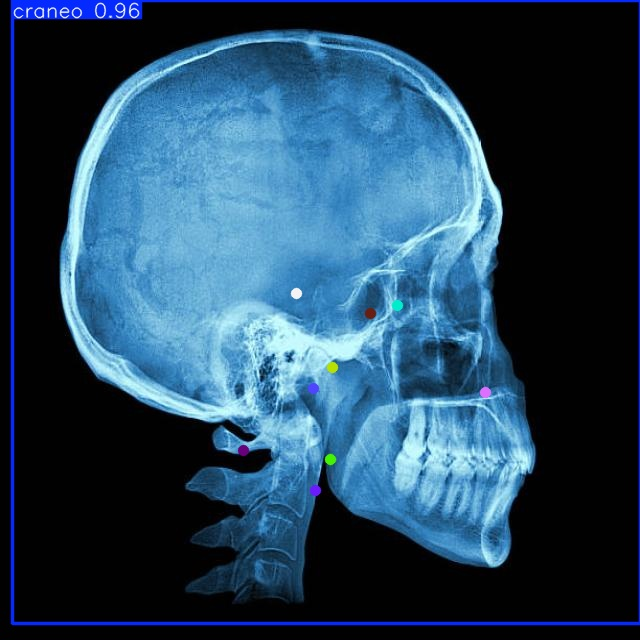

In [13]:
%cd {HOME}
model = YOLO('runs/pose/train/weights/best.pt')

import os
import glob
import random
from ultralytics import YOLO
from IPython.display import Image, display

# 1. Definimos HOME manualmente para arreglar el error
HOME = os.getcwd()

# 2. Cargar tu cerebro entrenado
# Usamos la ruta donde se guardó el entrenamiento
model = YOLO(f'{HOME}/runs/pose/train/weights/best.pt')

# 3. Buscar la imagen en la carpeta VALID (que sí existe)
try:
    # Intentamos usar la variable del dataset si existe
    image_folder = f"{dataset.location}/valid/images"
except NameError:
    # Si se borró la memoria, buscamos la carpeta automáticamente
    # Esto busca cualquier carpeta que termine en /valid/images
    posibles_carpetas = glob.glob(f"{HOME}/datasets/*/valid/images")
    if posibles_carpetas:
        image_folder = posibles_carpetas[0]
    else:
        print("¡Error! No encuentro la carpeta dataset. Asegúrate de haber descargado los datos.")

# Elegir una imagen al azar
image_files = os.listdir(image_folder)
random_file = random.choice(image_files)
image_path = os.path.join(image_folder, random_file)

print(f"Probando con la imagen: {image_path}")

# 4. Predecir y guardar
results = model.predict(source=image_path, save=True, conf=0.5)

# 5. Mostrar el resultado final
predict_folders = glob.glob(f'{HOME}/runs/pose/predict*')
latest_predict = max(predict_folders, key=os.path.getmtime)
result_image = os.path.join(latest_predict, random_file)

display(Image(filename=result_image))

We can visualize our keypoints using the following code:

In [ ]:
# Bug in Google Colab
import locale

locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install supervision==0.24.0 -q

import supervision as sv
import cv2

key_points = sv.KeyPoints.from_ultralytics(results[0])


vertex_annotator = sv.VertexAnnotator(radius=3, color=sv.Color.WHITE)
edge_annotator = sv.EdgeAnnotator(thickness=2, edges=[(0, 1)])

annotated_frame = cv2.imread(file_name)
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=key_points)

annotated_frame = sv.resize_image(
    annotated_frame,
    resolution_wh=(900, 900),
    keep_aspect_ratio=True
)
sv.cv2_to_pillow(annotated_frame)

Our model successfully identified keypoints in the image.

## Calculate Keypoint Angle

When you are working with keypoints, you may want to calculate the angle between two keypoints.

In this guide, we want to calculate whether the tip of the keypoint is at a 0 degree (or close to 0, within a set tolerance) angle to the base of the tip. This would indicate the glue stick is upright.

To do so, we can use the following code:

In [ ]:
import math

def check_angle_within_tolerance(xy, tolerance_degrees=5):
    p1, p2 = xy[0]

    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]

    angle_degrees = math.degrees(math.atan2(abs(dy), abs(dx))) if dx != 0 else 90

    return abs(angle_degrees - 0) <= tolerance_degrees

is_glue_upright = check_angle_within_tolerance(results[0].keypoints.xy)
is_glue_upright

## Save & Deploy model

Once you have finished training your YOLOv8 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/pose/train/weights/best.pt` folder of your project. You can upload and your model weights to Roboflow Deploy for autolabeling, autoscaling inference, and storage for later use.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) supports uploading YOLOv8 weights.

Run this cell to save your model weights:

In [ ]:
project.version(dataset.version).deploy(model_type="yolov8", model_path=f"{HOME}/runs/pose/train/")

Follow the links above to check if the upload succeeded. It may take a couple of minutes until the model is visible to the `roboflow` SDK.

In [ ]:
# Run inference on your model on a persistant, auto-scaling, cloud API

# Load model
model = project.version(dataset.version).model
assert model, "Model deployment is still loading"

# Choose a random test image
import os, random
test_set_loc = dataset.location + "/test/images/"
random_test_image = random.choice(os.listdir(test_set_loc))
print("running inference on " + random_test_image)

pred = model.predict(test_set_loc + random_test_image).json()
pred

# Deploy Your Model to the Edge

In addition to using the Roboflow hosted API for deployment, you can use [Roboflow Inference](https://inference.roboflow.com), an open source inference solution that has powered millions of API calls in production environments. Inference works with CPU and GPU, giving you immediate access to a range of devices, from the NVIDIA Jetson to TRT-compatible devices to ARM CPU devices.

With Roboflow Inference, you can self-host and deploy your model on-device.

To run inference on device, first install Inference:

```bash
pip install inference inference-sdk
```

Then, create a client through which to run your model:

```python
from inference_sdk import InferenceHTTPClient, InferenceConfiguration

project_id = ""
model_version = 1
confidence = 0.75

custom_configuration = InferenceConfiguration(confidence_threshold=confidence)

client = InferenceHTTPClient(
    api_url="http://localhost:9001",
    api_key=os.environ["API_KEY"],
)

client.select_api(model_version)
```


Above, set your Roboflow workspace ID, model ID, and API key.

- [Find your workspace and model ID](https://docs.roboflow.com/api-reference/workspace-and-project-ids?ref=blog.roboflow.com)
- [Find your API key](https://docs.roboflow.com/api-reference/authentication?ref=blog.roboflow.com#retrieve-an-api-key)

Then, you can run inference on a file:

```python
results = client.infer(image_url, model_id=f"{project_id}/{model_version}")

print(predictions)
```

_To use your YOLOv8 model commercially with Inference, you will need a Roboflow Enterprise license, through which you gain a pass-through license for using YOLOv8. An enterprise license also grants you access to features like advanced device management, multi-model containers, auto-batch inference, and more._

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.